# Libraries

In [2]:
import pandas as pd
import numpy as np
import optuna
import plotly
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [3]:
fixture = pd.read_csv('fixture.csv')
fixture

,year,round,date,time,region,venue,hteam,ateam,hscore,ascore,home_win,hdiff
0,2017,1,2017-03-26,14:50:00,SA,Adelaide Oval,Adelaide,Greater Western Sydney,147,91,1,56
1,2017,1,2017-03-23,19:20:00,VIC,M.C.G.,Carlton,Richmond,89,132,0,-43
2,2017,1,2017-03-24,19:50:00,VIC,M.C.G.,Collingwood,Western Bulldogs,86,100,0,-14
3,2017,1,2017-03-25,19:25:00,VIC,M.C.G.,Essendon,Hawthorn,116,91,1,25
4,2017,1,2017-03-26,16:40:00,WA,Subiaco,Fremantle,Geelong,73,115,0,-42
...,...,...,...,...,...,...,...,...,...,...,...,...
1408,2023,26,2023-09-15,19:50:00,VIC,M.C.G.,Melbourne,Carlton,71,73,0,-2
1409,2023,26,2023-09-16,19:10:00,SA,Adelaide Oval,Port Adelaide,Greater Western Sydney,70,93,0,-23
1410,2023,27,2023-09-23,17:15:00,QLD,Gabba,Brisbane Lions,Carlton,79,63,1,16
1411,2023,27,2023-09-22,19:50:00,VIC,M.C.G.,Collingwood,Greater Western Sydney,58,57,1,1


# Modeling

## Logistic Regression Model

In [4]:
fixture[fixture['year'] == 2023]

,year,round,date,time,region,venue,hteam,ateam,hscore,ascore,home_win,hdiff
1197,2023,1,2023-03-17,19:40:00,VIC,M.C.G.,Geelong,Collingwood,103,125,0,-22
1198,2023,1,2023-03-18,19:00:00,QLD,Carrara,Gold Coast,Sydney,61,110,0,-49
1199,2023,1,2023-03-19,13:10:00,NSW,Sydney Showground,Greater Western Sydney,Adelaide,106,90,1,16
1200,2023,1,2023-03-19,15:20:00,VIC,M.C.G.,Hawthorn,Essendon,65,124,0,-59
1201,2023,1,2023-03-18,19:25:00,VIC,M.C.G.,Melbourne,Western Bulldogs,115,65,1,50
...,...,...,...,...,...,...,...,...,...,...,...,...
1408,2023,26,2023-09-15,19:50:00,VIC,M.C.G.,Melbourne,Carlton,71,73,0,-2
1409,2023,26,2023-09-16,19:10:00,SA,Adelaide Oval,Port Adelaide,Greater Western Sydney,70,93,0,-23
1410,2023,27,2023-09-23,17:15:00,QLD,Gabba,Brisbane Lions,Carlton,79,63,1,16
1411,2023,27,2023-09-22,19:50:00,VIC,M.C.G.,Collingwood,Greater Western Sydney,58,57,1,1


In [5]:
# convert to datetime dtype and extract month and day
fixture['date'] = pd.to_datetime(fixture['date'])
fixture['month'] = fixture['date'].dt.month
fixture['day'] = fixture['date'].dt.day_name()

# Removing colons and converting time to integer
fixture['time_int'] = fixture['time'].str.replace(':', '').astype(int) / 100
fixture['time_int'] = fixture['time_int'].astype(int)

# convert dataframe to one-hot vector
fixture_oh = pd.get_dummies(fixture, columns=['region', 'hteam', 'ateam', 'day'], dtype='int')
fixture_oh

,year,round,date,time,venue,hscore,ascore,home_win,hdiff,month,...,ateam_Sydney,ateam_West Coast,ateam_Western Bulldogs,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,2017,1,2017-03-26,14:50:00,Adelaide Oval,147,91,1,56,3,...,0,0,0,0,0,0,1,0,0,0
1,2017,1,2017-03-23,19:20:00,M.C.G.,89,132,0,-43,3,...,0,0,0,0,0,0,0,1,0,0
2,2017,1,2017-03-24,19:50:00,M.C.G.,86,100,0,-14,3,...,0,0,1,1,0,0,0,0,0,0
3,2017,1,2017-03-25,19:25:00,M.C.G.,116,91,1,25,3,...,0,0,0,0,0,1,0,0,0,0
4,2017,1,2017-03-26,16:40:00,Subiaco,73,115,0,-42,3,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,2023,26,2023-09-15,19:50:00,M.C.G.,71,73,0,-2,9,...,0,0,0,1,0,0,0,0,0,0
1409,2023,26,2023-09-16,19:10:00,Adelaide Oval,70,93,0,-23,9,...,0,0,0,0,0,1,0,0,0,0
1410,2023,27,2023-09-23,17:15:00,Gabba,79,63,1,16,9,...,0,0,0,0,0,1,0,0,0,0
1411,2023,27,2023-09-22,19:50:00,M.C.G.,58,57,1,1,9,...,0,0,0,1,0,0,0,0,0,0


In [6]:
# Define your features and target variable
X = fixture_oh.drop(['home_win', 'ascore', 'hscore', 'hdiff', 'date', 'time', 'venue'], axis=1)
y = fixture_oh['home_win']

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [8]:
X_test

,year,round,month,time_int,region_ACT,region_CHN,region_NSW,region_NT,region_QLD,region_SA,...,ateam_Sydney,ateam_West Coast,ateam_Western Bulldogs,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
1271,2023,9,5,1930,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1272,2023,9,5,1640,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1273,2023,9,5,1635,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1274,2023,9,5,1410,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1275,2023,9,5,1920,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,2023,26,9,1950,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1409,2023,26,9,1910,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1410,2023,27,9,1715,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1411,2023,27,9,1950,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [9]:
# Create and fit the model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [10]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.48      0.53        64
           1       0.62      0.71      0.66        78

    accuracy                           0.61       142
   macro avg       0.60      0.59      0.59       142
weighted avg       0.60      0.61      0.60       142



In [11]:
def objective(trial):
    
    solver = 'lbfgs'
    # Suggest a penalty type
    penalty = trial.suggest_categorical('penalty', ['l2', None])


    # Suggest a value for C
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)

    # Model definition
    model = LogisticRegression(max_iter=500, C=C, penalty=penalty, solver='lbfgs')

    # Fit model
    model.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [26]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)  # You can adjust the number of trials

[I 2023-12-20 17:00:56,371] A new study created in memory with name: no-name-4d5267e2-2445-4e5b-882c-9141fd44f21c
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

[I 2023-12-20 17:00:56,449] Trial 0 finished with value: 0.5985915492957746 and parameters: {'penalty': None, 'C': 0.00014029123696180761}. Best is trial 0 with value: 0.5985915492957746.
[I 2023-12-20 17:00:56,477] Trial 1 finished with value: 0.5985915492957746 and parameters: {'penalty': 'l2', 'C': 2.7098837715357487}. Best is trial 0 with value: 0.5985915492957746.
[I 2023-12-20 17:00:56,497] Trial 2 finished with value: 0.5492957746478874 and parameters: {'penalty': 'l2', 'C': 0.0018331492272569267}. Best is trial 0 with value: 0.5985915492957746.
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

[I 2023-12-

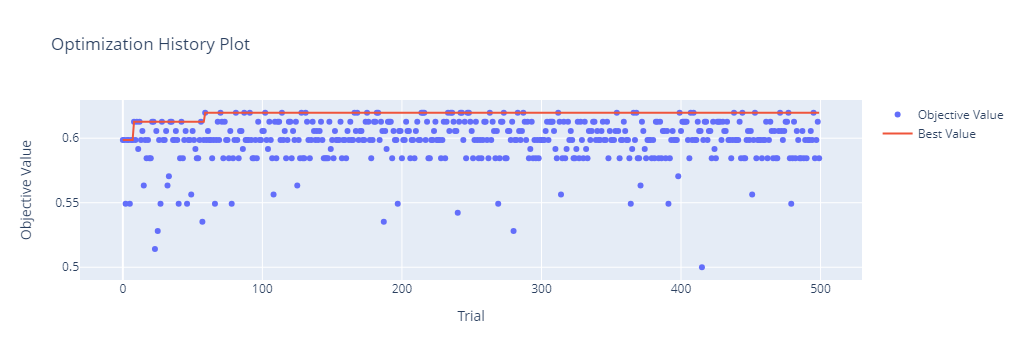

In [27]:
from optuna.visualization import plot_contour, plot_edf, plot_intermediate_values, plot_optimization_history, plot_parallel_coordinate
from optuna.visualization import plot_param_importances, plot_rank, plot_slice, plot_timeline
plot_optimization_history(study)

/tmp/ipykernel_21/3430271029.py:1: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



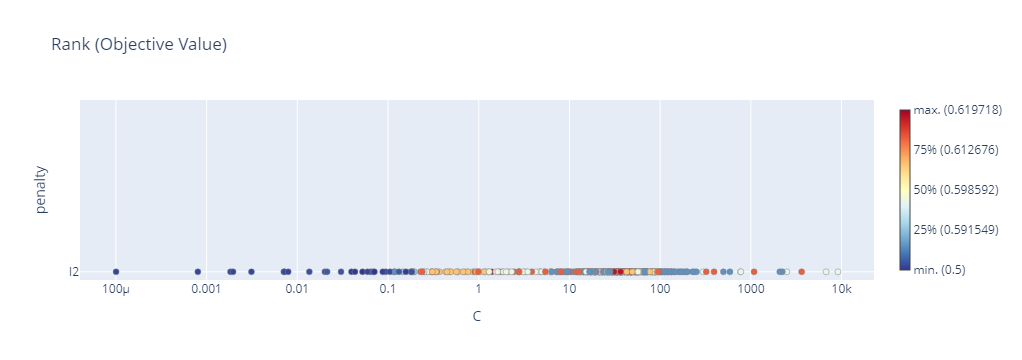

In [28]:
plot_rank(study)

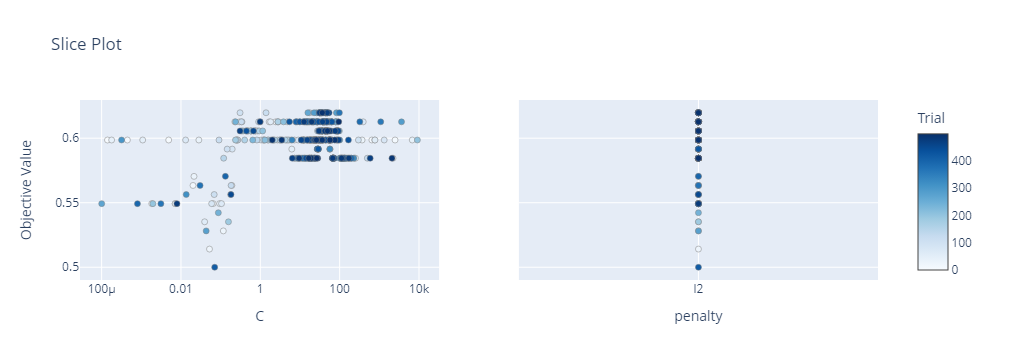

In [29]:
plot_slice(study)

'penalty': 'l2', 'C': 44.42325904081329

In [30]:
# Create and fit the model
model = LogisticRegression(max_iter=500, C=44.42325904081329, penalty='l2')
model.fit(X_train, y_train)

LogisticRegression(C=44.42325904081329, max_iter=500)

In [32]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.48      0.53        64
           1       0.63      0.73      0.68        78

    accuracy                           0.62       142
   macro avg       0.61      0.61      0.61       142
weighted avg       0.62      0.62      0.61       142

